## Analyze A/B Test Results


### Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusion](#conclusion)



<a id='probability'></a>
### Part I - Probability


In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# Set the seed to get the same answers on quizzes as Udacity set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
total = len(df)
users_conv = sum(df.converted)*100/total
users_conv

11.965919355605513

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Based on the above cell, no rows have missing values because they are all non-null values

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

In [11]:
len(df2)

290585

Based on the above cells, that means one user_id is a duplicate

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
#Checking the duplicate rows:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')

In [15]:
#Checking that the duplicate row was removed:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
total = len(df2)
users_conv = sum(df2.converted)/total
users_conv

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
total_con = df2.query('group == "control"').count()[0]
control_conv = df2.query('group == "control" and converted == 1').count()[0]/total_con
control_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
total_tre = total - total_con
treatment_conv = df2.query('group == "treatment" and converted == 1').count()[0]/total_tre
treatment_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
new_prob = df2.query('landing_page == "new_page"').count()[0]/total
new_prob

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based on the results, the control group has a higher conversion ratio than the treatment group. However, this is not sufficient evidence to reach a conclusion. Hypothesis testing should be used to reach a more accurate conclusion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<div align="center">$H_{0}$: $p_{new}$ - $p_{old}$ $\le$ 0

<div align="center">$H_{1}$: $p_{new}$ - $p_{old}$ $\gt$ 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = users_conv
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = users_conv
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = total_tre
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = total_con
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11686738696579727

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.1202761677932734

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
obs_diff = df2[df2['group']=='treatment']['converted'].mean() - df2[df2['group']=='control']['converted'].mean()
obs_diff

-0.0015782389853555567

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

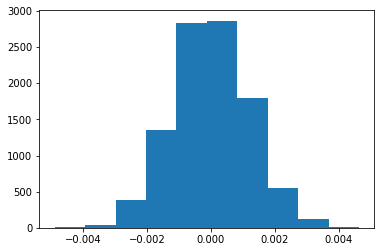

In [28]:
plt.hist(p_diffs);

**This plot looks like what I expected, which is that it is a normal distribution**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

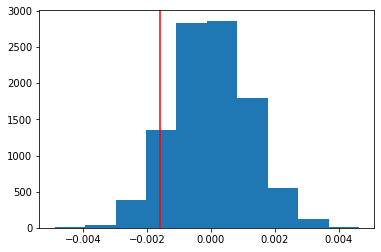

In [29]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red');

In [30]:
(p_diffs > obs_diff).mean()

0.9106

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value that was computed in part j is called the p-value, which was defined in the previous lessons as "the probability of observing your statistic if the null hypothesis is true." Since the p-value is significantly greater than the Type I error rate of 5%, this means that there is no difference between the new and old pages, which means that we should fail to reject the null hypothesis. This makes sense since we assumed that the conversion rate is the same for both the old and new pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
convert_old = df2.query('group == "control" and converted == 1').count()[0]
convert_new = df2.query('group == "treatment" and converted == 1').count()[0]
n_old = total_con
n_new = total_tre

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

In [33]:
z_score

-1.3109241984234394

In [34]:
p_value

0.9050583127590245

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Based on the above results, the p-value of 90.5% is still larger than the Type I error rate of 5%, which means that we have to fail to reject the null hypothesis. This conclusion agrees with the conclusion made in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since there are only two possible outcomes, logistic regression is going to be used in this case.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
#Creating an intercept column with a value of 1
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [36]:
#Creating the dummy variable columns and removing the unnecessary column (control)
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('control', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-05-23 23:46 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**The p-value associated with ab_page is 0.1899, which is higher than the p-value obtained in Part II of 0.0949. Furthermore, in part II it was a one-sided test, while in part III is a two-sided test.
Based on this regression model, the null hypothesis is that the old page and new page will both have the same conversion rate, and the alternative hypothesis is that the old page's conversion rate will be different from the new page's conversion rate.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Considering other factors into the regression model will yield more accurate results, because there could be other variables affecting the conversion rate. For example, the novelty effect and change aversion may have impacted the results if the experiment wasn't conducted for a long enough run time. Another example is that maybe the results differed based on time of day/week or seasonal events.**

**One of the disadvantages of adding additional terms to the regression model is that maybe two variables are dependent on each other, which will impact the conclusions we make if we are not aware of these dependencies.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
df2 = df2.set_index('user_id').join(df_countries.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [41]:
#Checking that the countries have no missing values
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 851104 to 715931
Data columns (total 7 columns):
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
dtypes: int64(2), object(4), uint8(1)
memory usage: 25.8+ MB


In [42]:
#Checking country column's unique values for the dummy variables
df2['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [43]:
#Creating the dummy variable columns and removing one of the columns (US)
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
df2 = df2.drop('US', axis=1)
df2.sample(10)

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
user_id,,,,,,,,,
902082,2017-01-16 18:14:25.057640,control,old_page,0,1,0,CA,1,0
788227,2017-01-18 07:10:27.170095,treatment,new_page,0,1,1,US,0,0
670260,2017-01-21 05:13:22.470808,treatment,new_page,0,1,1,US,0,0
760763,2017-01-16 06:49:49.322626,treatment,new_page,0,1,1,US,0,0
886955,2017-01-15 04:17:13.475227,control,old_page,0,1,0,US,0,0
748481,2017-01-04 20:45:22.143125,treatment,new_page,0,1,1,US,0,0
681365,2017-01-20 10:02:32.724655,control,old_page,0,1,0,US,0,0
905424,2017-01-13 03:12:19.464562,treatment,new_page,0,1,1,UK,0,1
771480,2017-01-04 06:02:29.345173,control,old_page,1,1,0,US,0,0


In [44]:
#Gathering the statistical info using logistic regression
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'CA', 'UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-05-23 23:46 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

**The above p-values for CA and UK of 0.1291 and 0.4558 are still significantly greater than the Type I error of 5%, which means that the country didn't have much effect for us to reject the null hypothesis.**

**All of the tests we made lead to the same conclusion, which is that we fail to reject the null hypothesis.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
#Creating two new columns that will multiply ab_page * either CA or UK
df2['ab_CA'] = df2['ab_page'] * df2['CA']
df2['ab_UK'] = df2['ab_page'] * df2['UK']
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,ab_CA,ab_UK
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,0,0


In [46]:
#Gathering the statistical insights
logit_mod = sm.Logit(df2['converted'], df2[['intercept','CA', 'UK', 'ab_CA', 'ab_UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.9259
Date:               2021-05-23 23:46 BIC:              212835.8241
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           4                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.27295    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
UK            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
ab_CA        -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
ab_UK         0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
==================================================================

"""

**The above results show that when combining ab_page and the country that the p-value was again larger than the Type I error of 5%. This means that we fail to reject the null hypothesis.**

<a id='conclusion'></a>
### Part IV - Conclusion

**In this project, we tried several methods to make sure we got the most accurate results. This included using probability, A/B testing and regression to see if the new page resulted in more conversions than the old page. However, all methods lead to the same conclusion, which is that the new page did not result in more conversions than the old page. This means that we fail to reject the null hypothesis.**


**Maybe in the future we can conduct the experiment for a longer period of time, or assess other variables to see if they have an effect on the conversion rate. We could also try to implement another new page and test whether it would lead to a higher conversion rate.**